<a href="https://colab.research.google.com/github/ladkrutarth/Classification-and-Regression-Models-Using-Deep-Learning/blob/main/Lab_2_Classification_and_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Dataset:

### Import required Libaray

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns


In [ ]:
# Cell 3: Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Dataset Preparation & Data split into train & test

In [ ]:

## 4.1 Load and preprocess the Diabetes Dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
print("Initial data shape:", X_diabetes.shape, y_diabetes.shape)

# Convert the target to binary for classification
threshold = y_diabetes.mean()
y_diabetes_binary = (y_diabetes > threshold).astype(int)
print("Threshold for classification:", threshold)
print("Binary target values (first 10):", y_diabetes_binary[:10])

# Train-test split for regression and classification
data_split = train_test_split(
    X_diabetes, y_diabetes, y_diabetes_binary, test_size=0.2, random_state=42
)
X_train_d, X_test_d, y_train_d, y_test_d, y_train_d_binary, y_test_d_binary = data_split
print("Train/Test split shapes:", X_train_d.shape, X_test_d.shape)

# Standardize features
scaler_d = StandardScaler()
X_train_d = scaler_d.fit_transform(X_train_d)
X_test_d = scaler_d.transform(X_test_d)
print("Sample standardized features (first 5 rows):", X_train_d[:5])

# Convert to PyTorch tensors
X_train_d_tensor = torch.tensor(X_train_d, dtype=torch.float32).to(device)
X_test_d_tensor = torch.tensor(X_test_d, dtype=torch.float32).to(device)
y_train_d_tensor = torch.tensor(y_train_d, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_tensor = torch.tensor(y_test_d, dtype=torch.float32).view(-1, 1).to(device)
y_train_d_binary_tensor = torch.tensor(y_train_d_binary, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_binary_tensor = torch.tensor(y_test_d_binary, dtype=torch.float32).view(-1, 1).to(device)

Initial data shape: (442, 10) (442,)
Threshold for classification: 152.13348416289594
Binary target values (first 10): [0 0 0 1 0 0 0 0 0 1]
Train/Test split shapes: (353, 10) (89, 10)
Sample standardized features (first 5 rows): [[ 1.49836523  1.06136988  0.21990201  1.13887373  0.72847289  1.05589332
  -0.82445065  0.71103773  0.54748197 -0.06144896]
 [-0.22885822  1.06136988 -0.41936607 -0.71059105 -0.4249289   0.27242452
  -1.52979055  1.4842858  -0.01975653  0.36723647]
 [ 0.08518241 -0.94217861  1.01898711  1.99247286 -0.30958872 -0.32669867
  -0.11911075 -0.06221033  0.3312366  -0.31866022]
 [-0.621409   -0.94217861 -0.78466212 -0.63945779 -1.17464007 -1.21550781
   0.66460025 -0.83545839 -1.06968217 -2.71929861]
 [-0.54289885 -0.94217861 -1.4239302  -1.7064567  -0.79978448 -1.11016747
   1.29156905 -1.60870645 -0.80285867 -0.91881982]]


### Build Feedforward Neural Network

In [ ]:
# Cell 5: Define the Feedforward Neural Network for Regression and Classification
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, classification=False):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        if classification:
            x = self.sigmoid(x)
        return x

# Initialize models
model_regression = FeedforwardNN(X_train_d.shape[1], 1).to(device)
model_classification = FeedforwardNN(X_train_d.shape[1], 1).to(device)
print("Models initialized.")

Models initialized.


In [ ]:
# Cell 6: Define Loss Functions and Optimizers
criterion_regression = nn.MSELoss()
criterion_classification = nn.BCELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.01)
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.01)
print("Loss functions and optimizers defined.")

Loss functions and optimizers defined.


### Train the Models

In [ ]:
def train_model(model, optimizer, X_train, y_train, criterion, epochs=100, classification=False):
    for epoch in range(epochs):
        model.train()
        inputs = X_train
        targets = y_train

        # Forward pass
        predictions = model(inputs, classification=classification)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Train the Regression model
print("Training Regression Model")
train_model(model_regression, optimizer_regression, X_train_d_tensor, y_train_d_tensor, criterion_regression)

# Train the Classification model
print("Training Classification Model")
train_model(model_classification, optimizer_classification, X_train_d_tensor, y_train_d_binary_tensor, criterion_classification, classification=True)

Training Regression Model
Epoch 10/100, Loss: 28268.5703
Epoch 20/100, Loss: 21616.1855
Epoch 30/100, Loss: 9138.0488
Epoch 40/100, Loss: 7153.7358
Epoch 50/100, Loss: 4356.5020
Epoch 60/100, Loss: 3706.2549
Epoch 70/100, Loss: 3321.3167
Epoch 80/100, Loss: 3020.2188
Epoch 90/100, Loss: 2897.3335
Epoch 100/100, Loss: 2810.3018
Training Classification Model
Epoch 10/100, Loss: 0.4901
Epoch 20/100, Loss: 0.4483
Epoch 30/100, Loss: 0.4156
Epoch 40/100, Loss: 0.3726
Epoch 50/100, Loss: 0.3106
Epoch 60/100, Loss: 0.2286
Epoch 70/100, Loss: 0.1486
Epoch 80/100, Loss: 0.0855
Epoch 90/100, Loss: 0.0476
Epoch 100/100, Loss: 0.0270


### Evaluate the Models & Build Graph

Regression predictions (first 5): [168.5274  184.62975 150.65485 312.05917  93.36616]
Regression Model - MSE: 2935.6104, R-squared: 0.4459
Classification predictions (first 5): [False False  True  True False]
Classification Model - Accuracy: 0.7528


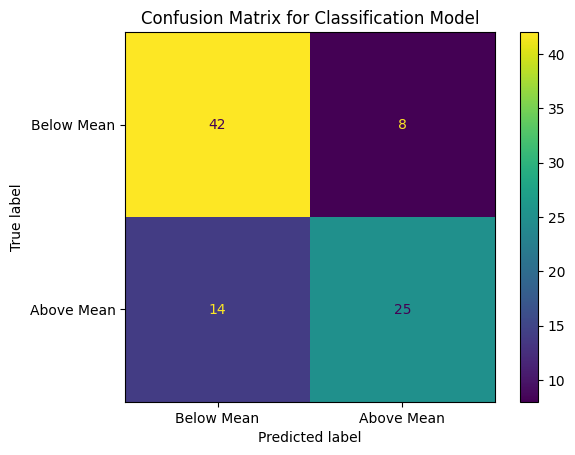

In [ ]:

def evaluate_model_regression(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        mse = mean_squared_error(y_test.cpu().numpy(), predictions)
        r2 = r2_score(y_test.cpu().numpy(), predictions)
        print("Regression predictions (first 5):", predictions[:5].flatten())
    return mse, r2

def evaluate_model_classification(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test, classification=True).cpu().numpy() > 0.5
        accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
        cm = confusion_matrix(y_test.cpu().numpy(), predictions)
        print("Classification predictions (first 5):", predictions[:5].flatten())
    return accuracy, cm

# Evaluate the Regression model
mse_d, r2_d = evaluate_model_regression(model_regression, X_test_d_tensor, y_test_d_tensor)
print(f"Regression Model - MSE: {mse_d:.4f}, R-squared: {r2_d:.4f}")

# Evaluate the Classification model
accuracy_d, cm_d = evaluate_model_classification(model_classification, X_test_d_tensor, y_test_d_binary_tensor)
print(f"Classification Model - Accuracy: {accuracy_d:.4f}")

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=["Below Mean", "Above Mean"]).plot()
plt.title("Confusion Matrix for Classification Model")
plt.show()

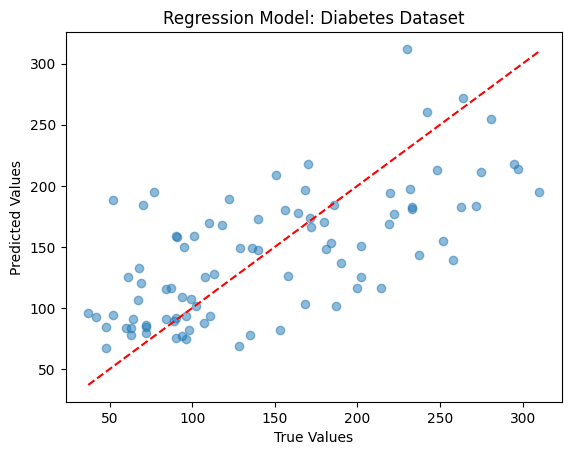

In [ ]:
# Cell 9: Visualize the Results
def plot_results_regression(y_test, predictions, title):
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Visualize results for the Regression model
with torch.no_grad():
    predictions_d = model_regression(X_test_d_tensor).cpu().numpy()
    plot_results_regression(y_test_d_tensor.cpu().numpy(), predictions_d, "Regression Model: Diabetes Dataset")

# California Housing Dataset.








### Load Dataset & Split data into test and train

In [5]:
# Import the necessary function
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X, y = data.data, data.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


### Define Neural Network for Regression

In [6]:

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### Train Regression Model

In [7]:

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 1.5565
Epoch [20/100], Loss: 0.8717
Epoch [30/100], Loss: 0.6693
Epoch [40/100], Loss: 0.5448
Epoch [50/100], Loss: 0.4683
Epoch [60/100], Loss: 0.4342
Epoch [70/100], Loss: 0.4130
Epoch [80/100], Loss: 0.3998
Epoch [90/100], Loss: 0.3896
Epoch [100/100], Loss: 0.3815


### Evaluate Regression Model

MSE: 0.3974, R2 Score: 0.6967


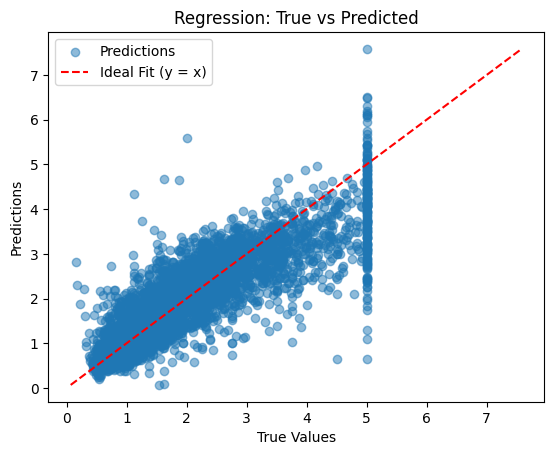

In [8]:

y_pred = model(X_test_tensor).detach().numpy()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.4f}, R2 Score: {r2:.4f}')

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")

# Reference line (y = x)
min_val = min(y_test.min(), y_pred.min())  # Get the minimum value from both y_test and y_pred
max_val = max(y_test.max(), y_pred.max())  # Get the maximum value from both y_test and y_pred
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Ideal Fit (y = x)")

# Labels and title
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Regression: True vs Predicted")
plt.legend()
plt.show()

Epoch [10/100], Loss: 0.4467
Epoch [20/100], Loss: 0.3752
Epoch [30/100], Loss: 0.3522
Epoch [40/100], Loss: 0.3334
Epoch [50/100], Loss: 0.3174
Epoch [60/100], Loss: 0.3128
Epoch [70/100], Loss: 0.3006
Epoch [80/100], Loss: 0.2954
Epoch [90/100], Loss: 0.2905
Epoch [100/100], Loss: 0.2862
Accuracy: 0.8748, Precision: 0.8684, Recall: 0.8815, F1-Score: 0.8749


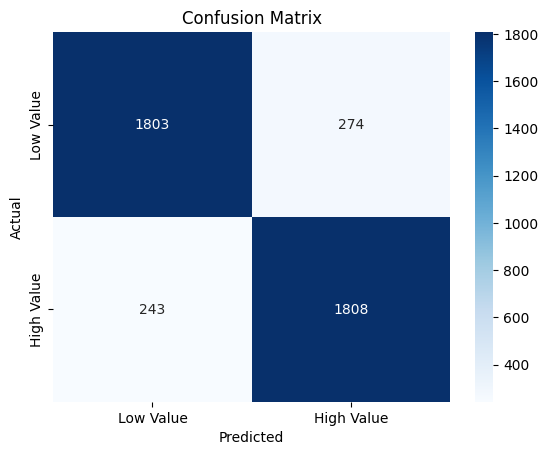

In [ ]:
# Classification Task
median_value = np.median(y)  # Define threshold
y_train_class = (y_train > median_value).astype(int)
y_test_class = (y_test > median_value).astype(int)

# Convert to PyTorch tensors
y_train_tensor_class = torch.tensor(y_train_class, dtype=torch.long)
y_test_tensor_class = torch.tensor(y_test_class, dtype=torch.long)

# Define Neural Network for Classification
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train Classification Model
model_class = ClassificationModel()
criterion_class = nn.CrossEntropyLoss()
optimizer_class = optim.Adam(model_class.parameters(), lr=0.01)

for epoch in range(num_epochs):
    optimizer_class.zero_grad()
    outputs = model_class(X_train_tensor)
    loss = criterion_class(outputs, y_train_tensor_class)
    loss.backward()
    optimizer_class.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate Classification Model
y_pred_class = model_class(X_test_tensor).argmax(dim=1).numpy()
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Value', 'High Value'], yticklabels=['Low Value', 'High Value'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()